# Introduction

Hi everyone, this is my beginner's attempt at tackling this famous Titanic Kaggle competition. I will first perform a EDA of the dataset, followed by data preprocessing and model implementation.

### Dataset Columns Summary

- **survival**: 0 = No, 1 = Yes
- **pclass**: 1 = 1st (the most expensive one), 2 = 2nd, 3 = 3rd
- **sex**: male, female
- **Age**: age of passenger
- **sibsp**: # of siblings/spouses aboard
- **parch**: % of parents/children aboard
- **ticket**: ticket id number
- **fare**: price paid 
- **cabin**: cabin assignment (not every passenger had one)
- **embarked**: C = Cherbourg, Q = Queenstown, S = Southampton

#### Importing datasets

In [1]:
import numpy as np
import pandas as pd 

df = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

# First glance at training data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

### Key Features
Before performing our EDA, we should identify the key features we want to analyze and base our models off of. Right off the bat, we can disregard passengerid, name, ticket, and embarked. This is because no matter what their name is or where they embarked from or what number their ticket is, it would not have impacted their chances of survival. These features below are what I believe to be the most important to analyze.
- **pclass**: 1st class had closer access to lifeboats
- **sex**: perhaps due to chivalric behavior, women were priotized more
- **age**: different priorties regarding children and elderly
- **sibsp**: having relatives could affect survivability due to priotizing relatives' lives
- **parch**: same reasoning as sibsp
- **fare**: higher fares correlate to higher class seating
- **cabin**: cabin locations affect survivability based off which ones are closest to lifeboats

#### Importing visualization packages

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Pclass and Sex columns

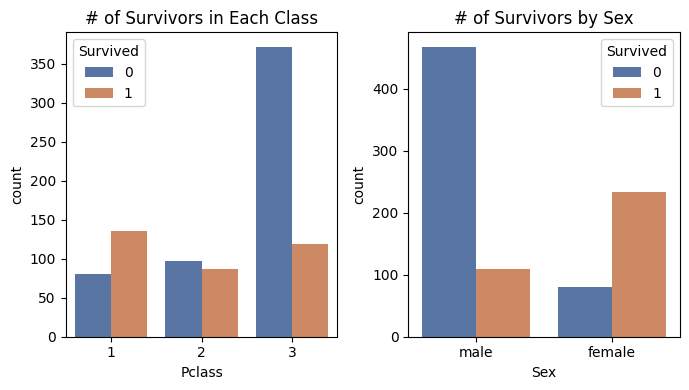

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(7,4))

# Pclass countplot visualization
sns.countplot(x=df['Pclass'], hue=df['Survived'], palette='deep', ax=axes[0])
axes[0].set_title("# of Survivors in Each Class")

# Gender countplot visualization
sns.countplot(x=df['Sex'], hue=df['Survived'], palette='deep', ax=axes[1])
axes[1].set_title("# of Survivors by Sex")

plt.tight_layout()
plt.show()

###### **Insights**
- The greatest amount of people survived in the 1st class while the greatest amount of people died in the 3rd class
- More females survived overall co

### Cabin column 

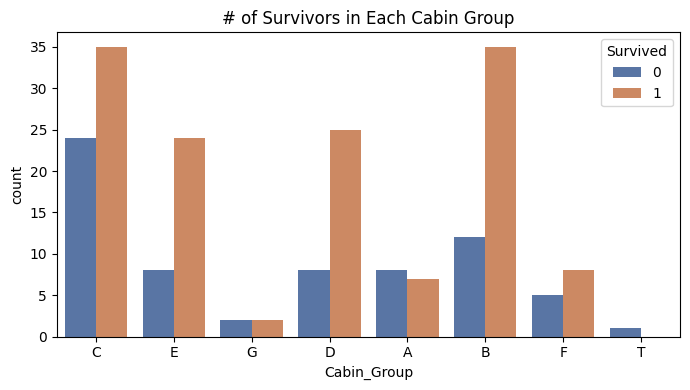

In [4]:
# Create a copy of our data to include a new column visualizing the cabin by groups
cabin_df = df.copy()
cabin_df['Cabin_Group'] = df['Cabin'].str[0]

plt.figure(figsize=(7,4))
sns.countplot(x=cabin_df['Cabin_Group'], hue=cabin_df['Survived'], palette='deep')
plt.title("# of Survivors in Each Cabin Group")
plt.tight_layout()
plt.show()

**Insight**
- The cabin groups with the most surviors are cabins B, C, D, and E.

### Age column 

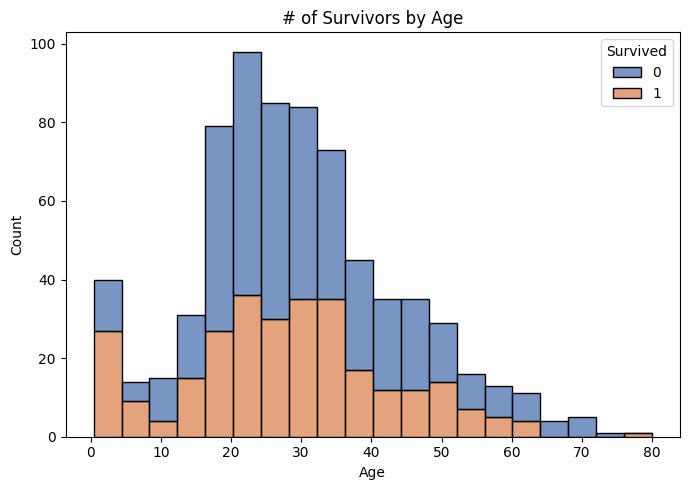

In [5]:
plt.figure(figsize=(7,5))
sns.histplot(x=df['Age'], hue=df['Survived'], multiple='stack', palette='deep')
plt.title("# of Survivors by Age")
plt.tight_layout()
plt.show()

**Insight**
- The amount of survivors by age has a slight right skew, meaning most of the survivors were of a younger age

### Fare column

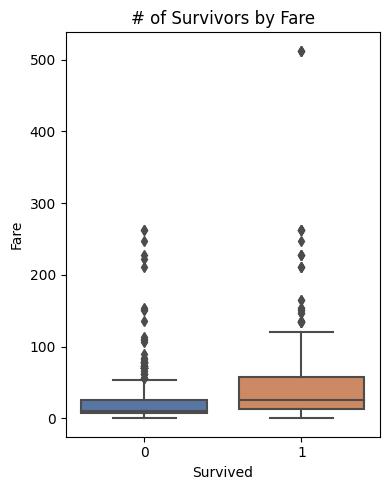

In [6]:
plt.figure(figsize=(4,5))
sns.boxplot(x=df['Survived'], y=df['Fare'], palette='deep')
plt.title("# of Survivors by Fare")
plt.tight_layout()
plt.show()

**Insight**
- As expected, the survivors had a higher median fare price than the people that did not survive.

### SibSp and Parch columns

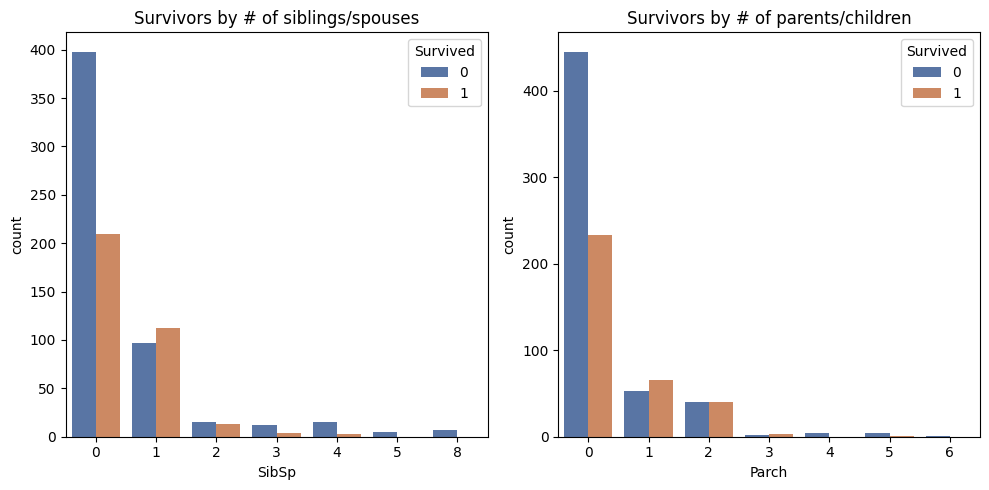

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Pclass countplot visualization
sns.countplot(x=df['SibSp'], hue=df['Survived'], ax=axes[0], palette='deep')
axes[0].set_title("Survivors by # of siblings/spouses")

# Gender countplot visualization
sns.countplot(x=df['Parch'], hue=df['Survived'], ax=axes[1], palette='deep')
axes[1].set_title("Survivors by # of parents/children")

plt.tight_layout()
plt.show()

**Insight**
- Proportionally, the best chance at survival are people with 0-2 siblings/spouses and 0-3 parents/children

# Data Pre-Processing

### Dropping Irrelevant Columns

In [8]:
irrelevant_columns = ['Name', 'Ticket', 'Embarked']
df.drop(columns=irrelevant_columns, axis=1, inplace=True)
test.drop(columns=irrelevant_columns, axis=1, inplace=True)

### Transforming Categorical Columns

In [9]:
# Use OneHotEncoder to transform categorical columns
from sklearn.preprocessing import OneHotEncoder

categorical = ['Pclass', 'Sex']
encoder = OneHotEncoder(drop='first', sparse=False) 
encoded_categories = encoder.fit_transform(df[categorical])
df_encoded = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical))
df = pd.concat([df, df_encoded], axis=1)
df.drop(columns=categorical, inplace=True)

# Do the same for test
test_encoded_categories = encoder.fit_transform(test[categorical])
test_encoded = pd.DataFrame(test_encoded_categories, columns=encoder.get_feature_names_out(categorical))
test = pd.concat([test, test_encoded], axis=1)
test.drop(columns=categorical, inplace=True)

### Replacing Missing Values

In [10]:
# Check which columns have missing values
print(f'Before:\n{df.isnull().sum()}')

# We use SimpleImputer to fill in the missing values with median, there are various other methods as well
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df['Age'] = imputer.fit_transform(df[["Age"]])

# Check we have successfully replaced missing values in 'Age'
print(f'\nAfter:\n{df.isnull().sum()}')

Before:
PassengerId      0
Survived         0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Pclass_2         0
Pclass_3         0
Sex_male         0
dtype: int64

After:
PassengerId      0
Survived         0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          687
Pclass_2         0
Pclass_3         0
Sex_male         0
dtype: int64


In [11]:
# Do the same for test data
print(f'Before:\n{test.isnull().sum()}')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
test['Age'] = imputer.fit_transform(test[["Age"]])
test['Fare'] = imputer.fit_transform(test[['Fare']])

# Check we have successfully replaced missing values in 'Age'
print(f'\nAfter:\n{test.isnull().sum()}')

Before:
PassengerId      0
Age             86
SibSp            0
Parch            0
Fare             1
Cabin          327
Pclass_2         0
Pclass_3         0
Sex_male         0
dtype: int64

After:
PassengerId      0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          327
Pclass_2         0
Pclass_3         0
Sex_male         0
dtype: int64


### Checking for Duplicates
As shown, there are no duplicates so no further action is needed.

In [12]:
print(f'Train Duplicates: \n{df[df.duplicated()].sum()}')
print(f'\nTest Duplicates:\n{test[test.duplicated()].sum()}')

Train Duplicates: 
PassengerId      0
Survived         0
Age            0.0
SibSp            0
Parch            0
Fare           0.0
Cabin            0
Pclass_2       0.0
Pclass_3       0.0
Sex_male       0.0
dtype: object

Test Duplicates:
PassengerId      0
Age            0.0
SibSp            0
Parch            0
Fare           0.0
Cabin            0
Pclass_2       0.0
Pclass_3       0.0
Sex_male       0.0
dtype: object


# Model Implementation

In [13]:
# Import packages
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

## Training & Testing Data

In [14]:
test.head()

,PassengerId,Age,SibSp,Parch,Fare,Cabin,Pclass_2,Pclass_3,Sex_male
0,892,34.5,0,0,7.8292,NaN,0.0,1.0,1.0
1,893,47.0,1,0,7.0000,NaN,0.0,1.0,0.0
2,894,62.0,0,0,9.6875,NaN,1.0,0.0,1.0
3,895,27.0,0,0,8.6625,NaN,0.0,1.0,1.0
4,896,22.0,1,1,12.2875,NaN,0.0,1.0,0.0


In [15]:
# Defining our training and testing data for model evaluation
y = df['Survived']
X = df.drop(columns = ['PassengerId', 'Survived', 'Cabin'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dropping Cabin column for now as I am not sure how to best implement it into a model

# Defining our actual test data to use for submission
final_test = test.drop(columns = ['PassengerId', 'Cabin'])

### Scaling Data

In [16]:
scaler = StandardScaler()
X_train[['Fare', 'Age']] = scaler.fit_transform(X_train[['Fare', 'Age']])
X_test[['Fare', 'Age']] = scaler.transform(X_test[['Fare', 'Age']])
final_test[['Fare', 'Age']] = scaler.transform(final_test[['Fare', 'Age']])

## Random Forest Base Model

In [17]:
# RF Base Model Results
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_train_prediction = rf_model.predict(X_test)
print(accuracy_score(y_test, rf_train_prediction))

0.8100558659217877


### Balanced Random Forest Model

In [18]:
brfc = BalancedRandomForestClassifier(random_state=42)
brfc.fit(X_train, y_train)
brfc_pred = brfc.predict(X_test)
print(accuracy_score(y_test, brfc_pred))

0.7932960893854749


## Logistic Regression Base Model

In [19]:
logreg_model = LogisticRegression(solver='liblinear', random_state=42)
logreg_model.fit(X_train, y_train)
logreg_pred = logreg_model.predict(X_test)
print(accuracy_score(y_test, logreg_pred))

0.8044692737430168


### Final Prediction

In [20]:
# Test Prediction
final_prediction = rf_model.predict(final_test)
output = pd.DataFrame({"PassengerId":test.PassengerId, "Survived":final_prediction})
output.to_csv('submission.csv', index=False)